In [2]:
from google.colab import drive
drive.mount('../content/drive')

Mounted at ../content/drive


In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage.feature import hog
from sklearn.preprocessing import LabelEncoder, StandardScaler, Normalizer
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error, mean_absolute_error, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.svm import SVC

path = '../content/drive/My Drive'
print(os.listdir(path))

['Classroom', 'skripsweet', 'datayoga', 'video', 'img', 'data', 'dataset', 'minced', 'Pneumonia', 'ontologi', 'dataset2', 'ontologi_tariJaipong3.owl', 'ontologi_tariJaipong4.owl', 'ontologi_tariJaipong5.owl', 'ontologi_tariJaipong2.owl', 'ontologi_tariJaipong.owl', 'File Tugas Akhir']


In [4]:
## read dataset

def dataset2(img_data):
  img_dt = []
  img_label = []

  for dir in os.listdir(img_data):
    for file in os.listdir(os.path.join(img_data, dir)):
      img_path = os.path.join(img_data, dir, file)
      img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
      img = cv2.resize(img, (img_width, img_height),  interpolation =cv2.INTER_LINEAR)
      #img = img_to_array(img)

      img_dt.append(img)
      img_label.append(dir)
  img_dt = np.asarray(img_dt)
  img_label = np.asarray(img_label)
  return img_dt, img_label

In [5]:
%%time
img_width = 280
img_height = 450
data = path+'/dataset2'
im_dt, lb_dt = dataset2(data)

CPU times: user 35.2 s, sys: 2.77 s, total: 38 s
Wall time: 15min 3s


In [6]:
im_dt.shape, lb_dt.shape

((2750, 450, 280), (2750,))

In [7]:
le = LabelEncoder()
#kls = le.classes_
y = le.fit_transform(lb_dt)

In [8]:
# resize-data cropping

def resize(img_data):
  images = []
  for img in img_data:
    img = cv2.resize(img, (width, height), interpolation = cv2.INTER_LINEAR)
    images.append(img)
  images = np.asarray(images)
  return images

In [9]:
width = 64
height = 128
im_rz = resize(im_dt)

im_rz.shape

(2750, 128, 64)

###**KNN Tanpa HOG**

In [10]:
x_train, x_test, y_train, y_test = train_test_split(im_rz, y, test_size=0.2, stratify=y, random_state=32)

In [11]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train, random_state=32)
x_train.shape, x_val.shape, x_test.shape

((1760, 128, 64), (440, 128, 64), (550, 128, 64))

In [12]:
print("Jumlah data train, test, val per kelas")
print("Training:", np.bincount(y_train))
print("Val:", np.bincount(y_val))
print("Test:", np.bincount(y_test))

Jumlah data train, test, val per kelas
Training: [141 141 133 134 134 138 141 139 128 128 128 141 134]
Val: [35 35 33 34 34 34 35 35 32 32 32 35 34]
Test: [44 44 42 42 42 43 44 43 40 40 40 44 42]


In [13]:
x_train = x_train.astype('float32')
x_train = x_train/255.0
x_val = x_val.astype('float32')
x_val = x_val/255.0
x_test = x_test.astype('float32')
x_test = x_test/255.0

In [14]:
#reshape
x_train = np.reshape(x_train, (x_train.shape[0], 128*64))
x_val = np.reshape(x_val, (x_val.shape[0], 128*64))
x_test = np.reshape(x_test, (x_test.shape[0], 128*64))

In [15]:
x_train.shape, x_val.shape, x_test.shape

((1760, 8192), (440, 8192), (550, 8192))

In [16]:
neigh = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

####**Running Model Tanpa HOG**

In [17]:
er1a= []
mse1a = []
acctr1a = []
pc1a=[]
rc1a = []
f11a = []

er1b= []
mse1b = []
accvl1b = []
pc1b =[]
rc1b = []
f11b = []
for k in neigh:
    knn= KNeighborsClassifier(n_neighbors=k, metric='manhattan')
    knn.fit(x_train,y_train)
    y_pred1= knn.predict(x_train)
    er1a.append(np.mean(y_train!= y_pred1))
    mse1 = mean_squared_error(y_train, y_pred1)
    mse1a.append(mse1)
    acctr1a.append(knn.score(x_train, y_train))
    pc1a.append(np.mean(precision_score(y_train, y_pred1, average='macro')))
    rc1a.append(np.mean(recall_score(y_train, y_pred1, average='macro')))
    f11a.append(np.mean(f1_score(y_train, y_pred1, average = 'macro')))

    y_pred2= knn.predict(x_val)
    er1b.append(np.mean(y_val!= y_pred2))
    mse2 = mean_squared_error(y_val, y_pred2)
    mse1b.append(mse2)
    accvl1b.append(knn.score(x_val, y_val))
    pc1b.append(np.mean(precision_score(y_val, y_pred2, average='macro')))
    rc1b.append(np.mean(recall_score(y_val, y_pred2, average='macro')))
    f11b.append(np.mean(f1_score(y_val, y_pred2, average = 'macro')))

In [18]:
print('presisi val: ',list(map(lambda x: '%.4f' % x, pc1b)))
print('recall val: ',list(map(lambda x: '%.4f' % x, rc1b)))
print('f1 val: ',list(map(lambda x: '%.4f' % x, f11b)))
print('accvl: ',list(map(lambda x: '%.4f' % x, accvl1b)))
print('mse val: ',list(map(lambda x: '%.4f' % x, mse1b)))
print('acctr: ',list(map(lambda x: '%.4f' % x, acctr1a)))
print('f1 train: ',list(map(lambda x: '%.4f' % x, f11a)))

presisi val:  ['0.9134', '0.8834', '0.8759', '0.8649', '0.8562', '0.8208', '0.8069', '0.7935', '0.8007', '0.7835', '0.7836', '0.7693', '0.7667']
recall val:  ['0.9134', '0.8805', '0.8760', '0.8594', '0.8502', '0.8222', '0.8106', '0.7989', '0.8011', '0.7821', '0.7799', '0.7617', '0.7595']
f1 val:  ['0.9112', '0.8770', '0.8709', '0.8547', '0.8456', '0.8135', '0.7993', '0.7878', '0.7899', '0.7663', '0.7656', '0.7470', '0.7458']
accvl:  ['0.9159', '0.8841', '0.8795', '0.8636', '0.8545', '0.8273', '0.8159', '0.8045', '0.8068', '0.7886', '0.7864', '0.7682', '0.7659']
mse val:  ['2.1727', '2.6068', '2.6614', '2.9591', '3.4841', '4.1841', '4.3886', '4.4250', '4.3682', '4.7227', '4.5432', '4.8727', '4.9636']
acctr:  ['0.9705', '0.9403', '0.9278', '0.9045', '0.8886', '0.8699', '0.8642', '0.8534', '0.8375', '0.8250', '0.8170', '0.8125', '0.7989']
f1 train:  ['0.9699', '0.9383', '0.9246', '0.8992', '0.8820', '0.8613', '0.8554', '0.8436', '0.8256', '0.8124', '0.8022', '0.7972', '0.7817']


In [19]:
er2a= []
mse2a = []
acctr2a = []
pc2a=[]
rc2a = []
f12a = []

er2b= []
mse2b = []
accvl2b = []
pc2b =[]
rc2b = []
f12b = []
for k in neigh:
    knne = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    knne.fit(x_train,y_train)
    y_pred1_e= knne.predict(x_train)
    er2a.append(np.mean(y_train!= y_pred1_e))
    mse1 = mean_squared_error(y_train, y_pred1_e)
    mse2a.append(mse1)
    acctr2a.append(knne.score(x_train, y_train))
    pc2a.append(np.mean(precision_score(y_train, y_pred1_e, average='macro')))
    rc2a.append(np.mean(recall_score(y_train, y_pred1_e, average='macro')))
    f12a.append(np.mean(f1_score(y_train, y_pred1_e, average = 'macro')))

    y_pred2= knne.predict(x_val)
    er2b.append(np.mean(y_val!= y_pred2))
    mse2 = mean_squared_error(y_val, y_pred2)
    mse2b.append(mse2)
    accvl2b.append(knne.score(x_val, y_val))
    pc2b.append(np.mean(precision_score(y_val, y_pred2, average='macro')))
    rc2b.append(np.mean(recall_score(y_val, y_pred2, average='macro')))
    f12b.append(np.mean(f1_score(y_val, y_pred2, average = 'macro')))

In [20]:
print('presisi val: ',list(map(lambda x: '%.4f' % x, pc2b)))
print('recall val: ',list(map(lambda x: '%.4f' % x, rc2b)))
print('f1 val: ',list(map(lambda x: '%.4f' % x, f12b)))
print('accvl: ',list(map(lambda x: '%.4f' % x, accvl2b)))
print('mse val: ',list(map(lambda x: '%.4f' % x, mse2b)))
print('acctr: ',list(map(lambda x: '%.4f' % x, acctr2a)))
print('f1 train: ',list(map(lambda x: '%.4f' % x, f12a)))

presisi val:  ['0.9017', '0.8905', '0.8794', '0.8558', '0.8424', '0.8145', '0.8067', '0.7886', '0.7688', '0.7529', '0.7466', '0.7400', '0.7245']
recall val:  ['0.8988', '0.8849', '0.8757', '0.8523', '0.8385', '0.8109', '0.8015', '0.7853', '0.7641', '0.7478', '0.7409', '0.7317', '0.7201']
f1 val:  ['0.8952', '0.8812', '0.8714', '0.8455', '0.8308', '0.8012', '0.7899', '0.7707', '0.7469', '0.7328', '0.7264', '0.7171', '0.7026']
accvl:  ['0.9023', '0.8886', '0.8795', '0.8568', '0.8432', '0.8159', '0.8068', '0.7909', '0.7705', '0.7545', '0.7477', '0.7386', '0.7273']
mse val:  ['2.0818', '2.3977', '2.6364', '2.7659', '3.2045', '3.8159', '3.7886', '4.4295', '4.9636', '5.1818', '5.2727', '5.5045', '5.5000']
acctr:  ['0.9659', '0.9386', '0.9239', '0.8977', '0.8739', '0.8625', '0.8494', '0.8415', '0.8301', '0.8165', '0.8091', '0.7926', '0.7818']
f1 train:  ['0.9651', '0.9360', '0.9204', '0.8921', '0.8662', '0.8541', '0.8379', '0.8293', '0.8174', '0.8028', '0.7947', '0.7764', '0.7641']


###**Menentukan Parameter HOG**

In [ ]:
## HOG
def hog_features(X):
  hog_img = []
  hog_feature = []
  for img in tqdm(X):
    blur = cv2.GaussianBlur(img, (5,5), 0) #filter gaussian blur
    hog_ft, hog_im = hog(img, orientations = 9, pixels_per_cell = (16,16), cells_per_block = (1,1), visualize = True, block_norm= 'L2-Hys')
    hog_img.append(hog_im)
    hog_feature.append(hog_ft)
  hog_img = np.asarray(hog_img)
  hog_feature = np.asarray(hog_feature)
  return hog_img, hog_feature

In [ ]:
im, ft = hog_features(im_rz)

100%|██████████| 2750/2750 [00:22<00:00, 123.48it/s]


Text(0.5, 1.0, 'jalak pengkor kanan')

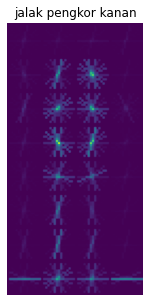

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (15,5))
ax.imshow(im[9])
ax.axis('off')
ax.set_title(lb_dt[9])

In [ ]:
train, test, l_train, l_test = train_test_split(ft, y, test_size=0.2, stratify=y, random_state=32)

In [ ]:
train, val, l_train, l_val = train_test_split(train, l_train, test_size=0.2, stratify=l_train, random_state=32)
train.shape, val.shape, test.shape

((1760, 9504), (440, 9504), (550, 9504))

In [ ]:
%%time
knn=KNeighborsClassifier()
knn.fit(train, l_train)
ypred=knn.predict(val)

acc = accuracy_score(l_val, ypred)
error = np.mean(l_val != ypred)
mse = mean_squared_error(l_val, ypred)
pc = precision_score(l_val, ypred, average='macro')
rc = recall_score(l_val, ypred, average='macro')
f1 = f1_score(l_val, ypred, average='macro')
print('Classifier: ', knn)
print('Precision: {:.4f}'.format(pc))
print('Recall: {:.4f}'.format(rc))
print('f1_score: {:.4f}'.format(f1))
print('Akurasi: {:.4f}'.format(acc))
print('MSE: {:.4f}'.format(mse))
print('Error: {:.4f}'.format(error))

Classifier:  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
Precision: 0.8966
Recall: 0.8938
f1_score: 0.8856
Akurasi: 0.8977
MSE: 2.2455
Error: 0.1023
CPU times: user 16.9 s, sys: 9.04 ms, total: 16.9 s
Wall time: 16.9 s


###**KNN HOG**

In [21]:
## HOG
def hog_features(X):
  hog_img = []
  hog_feature = []
  for img in tqdm(X):
    #kernel = np.ones((5,5),np.float32)/25
    #dst = cv2.filter2D(img,-1,kernel)
    gau = cv2.GaussianBlur(img, (5,5), 0) #filter gaussian blur
    hog_ft, hog_im = hog(gau, orientations = 9, pixels_per_cell = (8,8), cells_per_block = (2,2), visualize = True, block_norm= 'L2-Hys')
    hog_img.append(hog_im)
    hog_feature.append(hog_ft)
  hog_img = np.asarray(hog_img)
  hog_feature = np.asarray(hog_feature)
  return hog_img, hog_feature

In [22]:
hog_im, hog_ft = hog_features(im_rz)

100%|██████████| 2750/2750 [01:13<00:00, 37.41it/s]


In [23]:
hog_im.shape, hog_ft.shape

((2750, 128, 64), (2750, 3780))

Text(0.5, 1.0, 'jalak pengkor kanan')

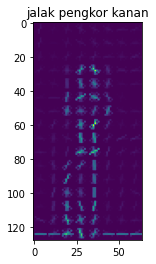

In [24]:
plt.imshow(hog_im[100])
plt.title(lb_dt[100])

In [25]:
X_train, X_test, Y_train, Y_test = train_test_split(hog_ft, y, test_size=0.2, stratify=y, random_state=32)

In [26]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, stratify=Y_train, random_state=32)
X_train.shape, X_val.shape, X_test.shape

((1760, 3780), (440, 3780), (550, 3780))

####**Running Model HOG**

In [27]:
er3a = []
mse3a = []
acctr3a = []
pc3a =[]
rc3a = []
f13a = []

er3b = []
mse3b = []
accvl3b = []
pc3b =[]
rc3b = []
f13b = []
for k in neigh:
    knn2 = KNeighborsClassifier(n_neighbors=k, metric='manhattan')
    knn2.fit(X_train, Y_train)
    Y_pred2 = knn2.predict(X_train)
    mse1 = mean_squared_error(Y_train, Y_pred2)
    er3a.append(np.mean(Y_train != Y_pred2))
    mse3a.append(mse1)
    acctr3a.append(knn2.score(X_train, Y_train))
    pc3a.append(np.mean(precision_score(Y_train, Y_pred2, average='macro')))
    rc3a.append(np.mean(recall_score(Y_train, Y_pred2, average='macro')))
    f13a.append(np.mean(f1_score(Y_train, Y_pred2, average='macro')))

    y_pred2= knn2.predict(X_val)
    er3b.append(np.mean(Y_val!= y_pred2))
    mse2 = mean_squared_error(Y_val, y_pred2)
    mse3b.append(mse2)
    accvl3b.append(accuracy_score(Y_val, y_pred2))
    pc3b.append(np.mean(precision_score(Y_val, y_pred2, average='macro')))
    rc3b.append(np.mean(recall_score(Y_val, y_pred2, average='macro')))
    f13b.append(np.mean(f1_score(Y_val, y_pred2, average='macro')))

In [28]:
print('presisi val: ',list(map(lambda x: '%.4f' % x, pc3b)))
print('recall val: ',list(map(lambda x: '%.4f' % x, rc3b)))
print('f1 val: ',list(map(lambda x: '%.4f' % x, f13b)))
print('accvl: ',list(map(lambda x: '%.4f' % x, accvl3b)))
print('mse val: ',list(map(lambda x: '%.4f' % x, mse3b)))
print('acctr: ',list(map(lambda x: '%.4f' % x, acctr3a)))
print('f1 train: ',list(map(lambda x: '%.4f' % x, f13a)))

presisi val:  ['0.9450', '0.9217', '0.9216', '0.9193', '0.8976', '0.8959', '0.8677', '0.8623', '0.8530', '0.8585', '0.8478', '0.8361', '0.8271']
recall val:  ['0.9437', '0.9206', '0.9203', '0.9183', '0.8951', '0.8951', '0.8669', '0.8599', '0.8480', '0.8548', '0.8455', '0.8363', '0.8266']
f1 val:  ['0.9417', '0.9181', '0.9164', '0.9148', '0.8907', '0.8912', '0.8569', '0.8509', '0.8388', '0.8456', '0.8366', '0.8281', '0.8162']
accvl:  ['0.9455', '0.9227', '0.9227', '0.9205', '0.8977', '0.8977', '0.8705', '0.8636', '0.8523', '0.8591', '0.8500', '0.8409', '0.8318']
mse val:  ['1.4614', '1.6795', '1.9864', '2.2455', '2.2545', '2.2432', '2.6659', '3.0023', '3.0636', '2.9523', '2.8977', '2.9773', '3.3955']
acctr:  ['0.9812', '0.9614', '0.9534', '0.9398', '0.9273', '0.9165', '0.9085', '0.9017', '0.8926', '0.8852', '0.8795', '0.8727', '0.8665']
f1 train:  ['0.9807', '0.9603', '0.9514', '0.9371', '0.9239', '0.9123', '0.9034', '0.8961', '0.8857', '0.8776', '0.8711', '0.8633', '0.8569']


In [29]:
er4a = []
mse4a = []
acctr4a = []
pc4a =[]
rc4a = []
f14a = []

er4b = []
mse4b = []
accvl4b = []
pc4b =[]
rc4b = []
f14b = []
for k in neigh:
    knn1 = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    knn1.fit(X_train, Y_train)
    Y_pred1 = knn1.predict(X_train)
    mse1 = mean_squared_error(Y_train, Y_pred1)
    er4a.append(np.mean(Y_train != Y_pred1))
    mse4a.append(mse1)
    acctr4a.append(knn1.score(X_train, Y_train))
    pc4a.append(np.mean(precision_score(Y_train, Y_pred1, average='macro')))
    rc4a.append(np.mean(recall_score(Y_train, Y_pred1, average='macro')))
    f14a.append(np.mean(f1_score(Y_train, Y_pred1, average='macro')))

    y_pred2= knn1.predict(X_val)
    mse2 = mean_squared_error(Y_val, y_pred2)
    er4b.append(np.mean(Y_val!= y_pred2))
    mse4b.append(mse2)
    accvl4b.append(accuracy_score(Y_val, y_pred2))
    pc4b.append(np.mean(precision_score(Y_val, y_pred2, average='macro')))
    rc4b.append(np.mean(recall_score(Y_val, y_pred2, average='macro')))
    f14b.append(np.mean(f1_score(Y_val, y_pred2, average='macro')))

In [30]:
print('presisi val: ',list(map(lambda x: '%.4f' % x, pc4b)))
print('recall val: ',list(map(lambda x: '%.4f' % x, rc4b)))
print('f1 val: ',list(map(lambda x: '%.4f' % x, f14b)))
print('accvl: ',list(map(lambda x: '%.4f' % x, accvl4b)))
print('mse val: ',list(map(lambda x: '%.4f' % x, mse4b)))
print('acctr: ',list(map(lambda x: '%.4f' % x, acctr4a)))
print('f1 train: ',list(map(lambda x: '%.4f' % x, f14a)))

presisi val:  ['0.9501', '0.9335', '0.9359', '0.9305', '0.9151', '0.9019', '0.8794', '0.8687', '0.8516', '0.8459', '0.8427', '0.8323', '0.8351']
recall val:  ['0.9483', '0.9323', '0.9342', '0.9275', '0.9138', '0.8999', '0.8811', '0.8696', '0.8530', '0.8483', '0.8435', '0.8340', '0.8343']
f1 val:  ['0.9472', '0.9305', '0.9313', '0.9248', '0.9113', '0.8964', '0.8735', '0.8626', '0.8455', '0.8406', '0.8361', '0.8250', '0.8241']
accvl:  ['0.9500', '0.9341', '0.9364', '0.9295', '0.9159', '0.9023', '0.8841', '0.8727', '0.8568', '0.8523', '0.8477', '0.8386', '0.8386']
mse val:  ['1.4295', '1.7000', '1.5659', '1.8409', '2.0386', '2.4841', '3.0886', '3.2818', '3.6432', '3.6341', '3.6545', '3.7205', '3.9386']
acctr:  ['0.9835', '0.9665', '0.9574', '0.9375', '0.9233', '0.9193', '0.9097', '0.9091', '0.8955', '0.8869', '0.8812', '0.8761', '0.8744']
f1 train:  ['0.9831', '0.9656', '0.9556', '0.9350', '0.9200', '0.9157', '0.9049', '0.9045', '0.8889', '0.8797', '0.8733', '0.8679', '0.8657']


###**PLOT**

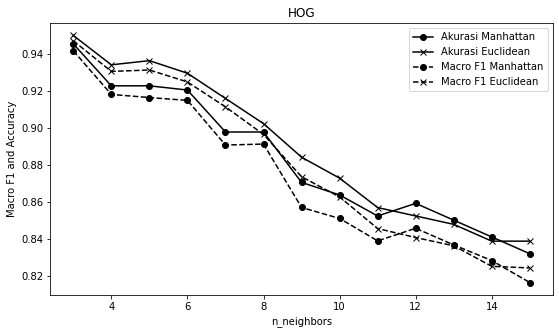

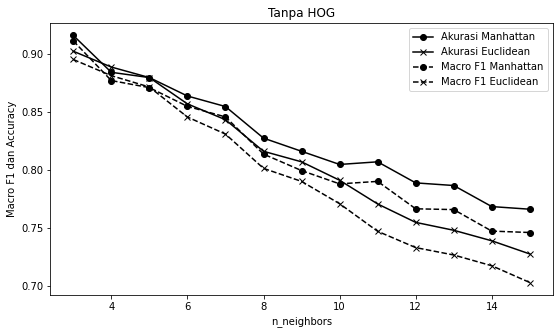

In [32]:
## PLOT HOG
plt.figure(figsize = (9,5))
plt.plot(neigh, accvl3b, linestyle ='solid', marker="o", color="#000000", label='Akurasi Manhattan')
plt.plot(neigh, accvl4b, linestyle ='solid', marker="x", color="#000000", label = 'Akurasi Euclidean')
plt.plot(neigh, f13b, linestyle ='dashed', marker="o", color="#000000", label = 'Macro F1 Manhattan')
plt.plot(neigh, f14b, linestyle ='dashed', marker="x", color="#000000", label = 'Macro F1 Euclidean')
plt.xlabel('n_neighbors')
plt.ylabel('Macro F1 and Accuracy')
plt.title('HOG')
plt.legend()
plt.show()

## PLOT Tanpa HOG
plt.figure(figsize = (9,5))
plt.plot(neigh, accvl1b, linestyle ='solid', marker="o", color="#000000", label='Akurasi Manhattan')
plt.plot(neigh, accvl2b, linestyle ='solid', marker="x", color="#000000", label = 'Akurasi Euclidean')
plt.plot(neigh, f11b, linestyle ='dashed', marker="o", color="#000000", label = 'Macro F1 Manhattan')
plt.plot(neigh, f12b, linestyle ='dashed', marker="x", color="#000000", label = 'Macro F1 Euclidean')
plt.xlabel('n_neighbors')
plt.ylabel('Macro F1 dan Accuracy')
plt.title('Tanpa HOG')
plt.legend()
plt.show()

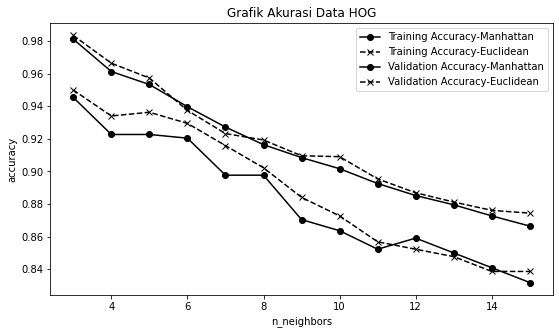

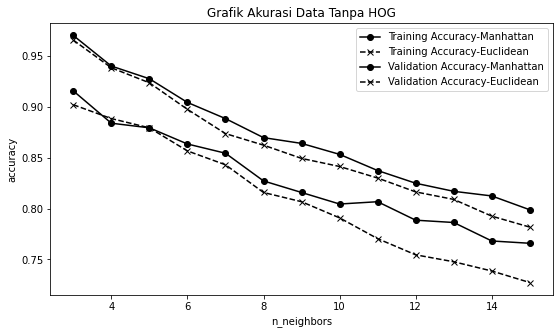

In [33]:
## PLOT Akurasi HOG
plt.figure(figsize = (9,5))
plt.plot(neigh, acctr3a, linestyle ='solid', marker="o", color="#000000", label='Training Accuracy-Manhattan')
plt.plot(neigh, acctr4a, linestyle ='dashed', marker="x", color="#000000", label = 'Training Accuracy-Euclidean')
plt.plot(neigh, accvl3b, linestyle ='solid', marker="o", color="#000000", label = 'Validation Accuracy-Manhattan')
plt.plot(neigh, accvl4b, linestyle ='dashed', marker="x", color="#000000", label = 'Validation Accuracy-Euclidean')
plt.xlabel('n_neighbors')
plt.ylabel('accuracy')
plt.title('Grafik Akurasi Data HOG')
plt.legend()
plt.show()

## PLOT Akurasi Tanpa HOG
plt.figure(figsize = (9,5))
plt.plot(neigh, acctr1a, linestyle ='solid', marker="o", color="#000000", label='Training Accuracy-Manhattan')
plt.plot(neigh, acctr2a, linestyle ='dashed', marker="x", color="#000000", label = 'Training Accuracy-Euclidean')
plt.plot(neigh, accvl1b, linestyle ='solid', marker="o", color="#000000", label = 'Validation Accuracy-Manhattan')
plt.plot(neigh, accvl2b, linestyle ='dashed', marker="x", color="#000000", label = 'Validation Accuracy-Euclidean')
plt.xlabel('n_neighbors')
plt.ylabel('accuracy')
plt.title('Grafik Akurasi Data Tanpa HOG')
plt.legend()
plt.show()

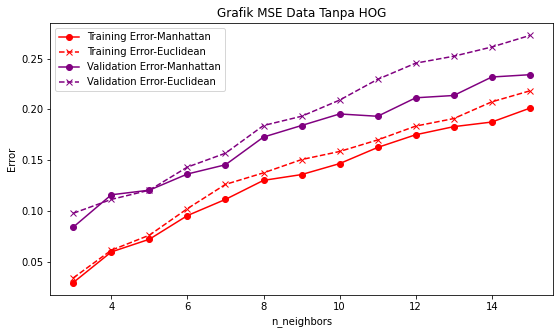

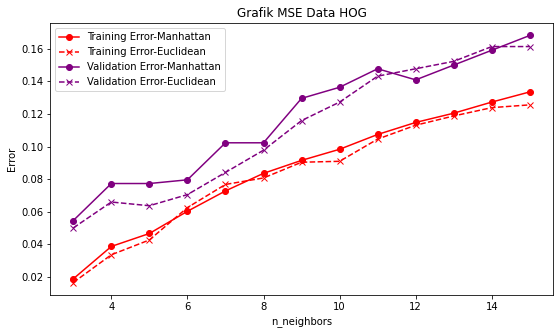

In [35]:
## PLOT Error Tanpa HOG
plt.figure(figsize = (9,5))
plt.plot(neigh, er1a, linestyle ='solid', marker="o", color="red", label='Training Error-Manhattan')
plt.plot(neigh, er2a, linestyle ='dashed', marker="x", color="red", label = 'Training Error-Euclidean')
plt.plot(neigh, er1b, linestyle ='solid', marker="o", color="purple", label = 'Validation Error-Manhattan')
plt.plot(neigh, er2b, linestyle ='dashed', marker="x", color="purple", label = 'Validation Error-Euclidean')
plt.xlabel('n_neighbors')
plt.ylabel('Error')
plt.title('Grafik MSE Data Tanpa HOG')
plt.legend()
plt.show()

## PLOT Error HOG
plt.figure(figsize = (9,5))
plt.plot(neigh, er3a, linestyle ='solid', marker="o", color="red", label='Training Error-Manhattan')
plt.plot(neigh, er4a, linestyle ='dashed', marker="x", color="red", label = 'Training Error-Euclidean')
plt.plot(neigh, er3b, linestyle ='solid', marker="o", color="purple", label = 'Validation Error-Manhattan')
plt.plot(neigh, er4b, linestyle ='dashed', marker="x", color="purple", label = 'Validation Error-Euclidean')
plt.xlabel('n_neighbors')
plt.ylabel('Error')
plt.title('Grafik MSE Data HOG')
plt.legend()
plt.show()

###**Akurasi Data Tes**

In [31]:
neigh2 = [3,4,5]

In [34]:
### DATA HOG
## menggunakan neighbors sebelumnya dengan menggunakan metric Euclidean

%%time
pc4c = []
rc4c = []
f14c = []
accts4c = []
mse4c = []
er4c = []
for k in neigh2:
  knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
  knn.fit(X_train, Y_train)
  y_pred = knn.predict(X_test)

  accts4c.append(accuracy_score(y_test, y_pred))
  f14c.append(f1_score(y_test, y_pred, average='macro'))
  mse4c.append(mean_squared_error(y_test, y_pred))
  er4c.append(np.mean(y_test != y_pred))
  pc4c.append(precision_score(y_test, y_pred, average='macro'))
  rc4c.append(recall_score(y_test, y_pred, average='macro'))

CPU times: user 25.1 s, sys: 26.9 ms, total: 25.1 s
Wall time: 25 s


In [35]:
print('acctr: ',list(map(lambda x: '%.4f' % x, acctr4a)))
print('accvl: ',list(map(lambda x: '%.4f' % x, accvl4b)))
print('\n')
print('accts: ',list(map(lambda x: '%.4f' % x, accts4c)))
print('f1 tes: ',list(map(lambda x: '%.4f' % x, f14c)))
print('mse tes: ',list(map(lambda x: '%.4f' % x, mse4c)))
print('\n')
print('presisi tes: ',list(map(lambda x: '%.4f' % x, pc4c)))
print('recall tes: ',list(map(lambda x: '%.4f' % x, rc4c)))

acctr:  ['0.9835', '0.9665', '0.9574', '0.9375', '0.9233', '0.9193', '0.9097', '0.9091', '0.8955', '0.8869', '0.8812', '0.8761', '0.8744']
accvl:  ['0.9500', '0.9341', '0.9364', '0.9295', '0.9159', '0.9023', '0.8841', '0.8727', '0.8568', '0.8523', '0.8477', '0.8386', '0.8386']


accts:  ['0.9309', '0.9182', '0.9109']
f1 tes:  ['0.9284', '0.9152', '0.9068']
mse tes:  ['1.5455', '1.7509', '1.6091']


presisi tes:  ['0.9321', '0.9184', '0.9130']
recall tes:  ['0.9294', '0.9164', '0.9087']


In [36]:
### DATA TANPA HOG
## menggunakan neighbors sebelumnya dengan menggunakan metric Euclidean

%%time
accts1c = []
pc1c = []
rc1c = []
mse1c = []
er1c = []
f11c = []
for k in neigh2:
  knn2 = KNeighborsClassifier(n_neighbors=k, metric='manhattan')
  knn2.fit(x_train, y_train)
  y_pred2 = knn2.predict(x_test)

  accts1c.append(accuracy_score(y_test, y_pred2))
  er1c.append(np.mean(y_test != y_pred2))
  mse1c.append(mean_squared_error(y_test, y_pred2))
  pc1c.append(precision_score(y_test, y_pred2, average='macro'))
  rc1c.append(recall_score(y_test, y_pred2, average='macro'))
  f11c.append(f1_score(y_test, y_pred2, average='macro'))

CPU times: user 41.1 s, sys: 47.8 ms, total: 41.2 s
Wall time: 41 s


In [37]:
print('acctr: ',list(map(lambda x: '%.4f' % x, acctr1a)))
print('accvl: ',list(map(lambda x: '%.4f' % x, accvl1b)))
print('\n')
print('accts: ',list(map(lambda x: '%.4f' % x, accts1c)))
print('f1 tes: ',list(map(lambda x: '%.4f' % x, f11c)))
print('mse tes: ',list(map(lambda x: '%.4f' % x, mse1c)))
print('\n')
print('presisi tes: ',list(map(lambda x: '%.4f' % x, pc1c)))
print('recall tes: ',list(map(lambda x: '%.4f' % x, rc1c)))

acctr:  ['0.9705', '0.9403', '0.9278', '0.9045', '0.8886', '0.8699', '0.8642', '0.8534', '0.8375', '0.8250', '0.8170', '0.8125', '0.7989']
accvl:  ['0.9159', '0.8841', '0.8795', '0.8636', '0.8545', '0.8273', '0.8159', '0.8045', '0.8068', '0.7886', '0.7864', '0.7682', '0.7659']


accts:  ['0.9091', '0.8782', '0.8618']
f1 tes:  ['0.9069', '0.8743', '0.8559']
mse tes:  ['2.3436', '3.0182', '3.2182']


presisi tes:  ['0.9079', '0.8768', '0.8632']
recall tes:  ['0.9074', '0.8754', '0.8589']


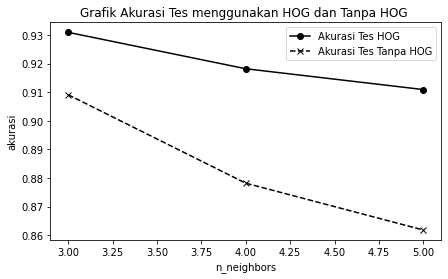

In [45]:
## PLOT AKURASI TES
plt.figure(figsize = (7,4))
plt.plot(neigh2, accts4c, linestyle ='solid', marker='o', color="black", label = 'Akurasi Tes HOG')
plt.plot(neigh2, accts1c, linestyle ='dashed', marker='x', color="black", label = 'Akurasi Tes Tanpa HOG')
plt.xlabel('n_neighbors')
plt.ylabel('akurasi')
plt.title('Grafik Akurasi Tes menggunakan HOG dan Tanpa HOG ')
plt.legend()
plt.show()

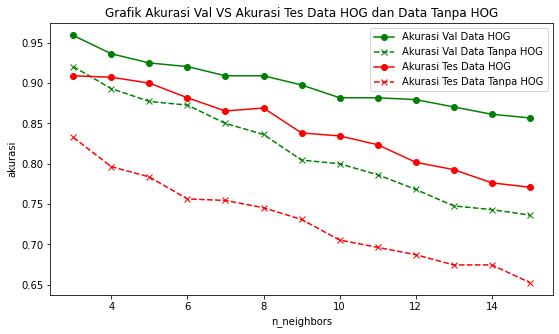

In [ ]:
## PLOT AKURASI VAL VS TES
plt.figure(figsize = (9,5))
plt.plot(neigh, accvl4b, linestyle ='solid', marker='o', color="green", label='Akurasi Val Data HOG')
plt.plot(neigh, accvl1b, linestyle ='dashed', marker='x', color="green", label = 'Akurasi Val Data Tanpa HOG')
plt.plot(neigh, accts4c, linestyle ='solid', marker='o', color="red", label = 'Akurasi Tes Data HOG')
plt.plot(neigh, accts1c, linestyle ='dashed', marker='x', color="red", label = 'Akurasi Tes Data Tanpa HOG')
plt.xlabel('n_neighbors')
plt.ylabel('akurasi')
plt.title('Grafik Akurasi Val VS Akurasi Tes Data HOG dan Data Tanpa HOG')
plt.legend()
plt.show()

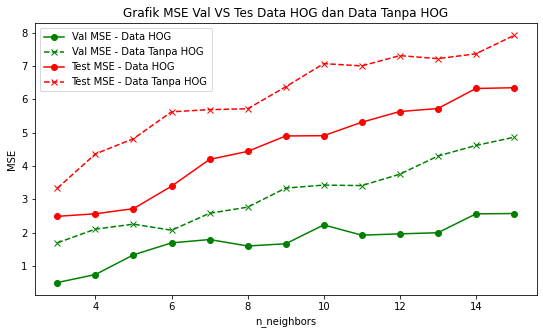

In [ ]:
## PLOT MSE VAL VS TES
plt.figure(figsize = (9,5))
plt.plot(neigh, mse4b, linestyle ='solid', marker='o', color="green", label='Val MSE - Data HOG')
plt.plot(neigh, mse1b, linestyle ='dashed', marker='x', color="green", label = 'Val MSE - Data Tanpa HOG')
plt.plot(neigh, mse4c, linestyle ='solid', marker='o', color="red", label = 'Test MSE - Data HOG')
plt.plot(neigh, mse1c, linestyle ='dashed', marker='x',color="red", label = 'Test MSE - Data Tanpa HOG')
plt.xlabel('n_neighbors')
plt.ylabel('MSE')
plt.title('Grafik MSE Val VS Tes Data HOG dan Data Tanpa HOG')
plt.legend()
plt.show()

###**Klasifikasi Gambar** 

In [ ]:
## HOG n= 3
%%time
knn = KNeighborsClassifier(n_neighbors=3, metric='euclidean')
knn.fit(X_train, Y_train)
y_pred = knn.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
error = np.mean(y_test != y_pred)
print('akurasi test: {:.4f}'.format(acc))
print('f1 test: {:.4f}'.format(f1))
print('error test: {:.4f}'.format(error))

akurasi test: 0.9091
f1 test: 0.9039
error test: 0.0909
CPU times: user 8.28 s, sys: 9.95 ms, total: 8.29 s
Wall time: 8.25 s


In [ ]:
ypred = le.inverse_transform(y_pred)

Text(33.0, 0.5, 'prediction label')

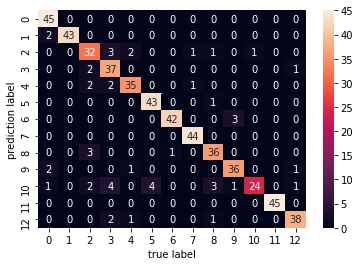

In [ ]:
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('true label')
plt.ylabel('prediction label')

In [ ]:
df_report = pd.DataFrame(cm,columns = le.classes_ )
df_report.index = [le.classes_]
df_report

,adeg-adeg,cindek,galeong jedag,jalak pengkor kanan,jalak pengkor kiri,kanan tarik,kiri tarik,obah bahu,ranggah kanan kiri,selut capang,selut jambret,sembah,tumpang tali
adeg-adeg,45,0,0,0,0,0,0,0,0,0,0,0,0
cindek,2,43,0,0,0,0,0,0,0,0,0,0,0
galeong jedag,0,0,32,3,2,0,0,1,1,0,1,0,0
jalak pengkor kanan,0,0,2,37,0,0,0,0,0,0,0,0,1
jalak pengkor kiri,0,0,2,2,35,0,0,1,0,0,0,0,0
kanan tarik,0,0,0,0,0,43,0,0,1,0,0,0,0
kiri tarik,0,0,0,0,0,0,42,0,0,3,0,0,0
obah bahu,0,0,0,0,0,0,0,44,0,0,0,0,0
ranggah kanan kiri,0,0,3,0,0,0,1,0,36,0,0,0,0
selut capang,2,0,0,0,1,0,0,0,0,36,0,0,1


In [ ]:
## Tanpa HOG n=3
%%time
knn3 = KNeighborsClassifier(n_neighbors=3, metric='euclidean')
knn3.fit(x_train, y_train)
y_pred3 = knn3.predict(x_test)
acc3 = accuracy_score(y_test, y_pred3)
error3 = np.mean(y_test != y_pred3)
print('akurasi test: {:.4f}'.format(acc3))
print('error test: {:.4f}'.format(error3))

akurasi test: 0.8327
error test: 0.1673
CPU times: user 12.5 s, sys: 23 ms, total: 12.5 s
Wall time: 12.5 s


In [ ]:
ypred3 = le.inverse_transform(y_pred3)

Text(33.0, 0.5, 'prediction label')

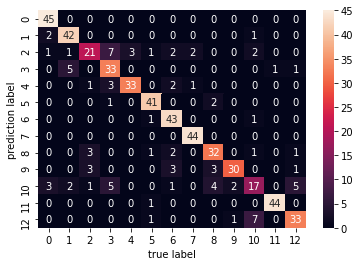

In [ ]:
import seaborn as sns
cm3 = confusion_matrix(y_test, y_pred3)
ax = sns.heatmap(cm3, annot=True, fmt="d")
plt.xlabel('true label')
plt.ylabel('prediction label')

In [ ]:
df_report3 = pd.DataFrame(cm3,columns = le.classes_ )
df_report3.index = [le.classes_]
df_report3

,adeg-adeg,cindek,galeong jedag,jalak pengkor kanan,jalak pengkor kiri,kanan tarik,kiri tarik,obah bahu,ranggah kanan kiri,selut capang,selut jambret,sembah,tumpang tali
adeg-adeg,45,0,0,0,0,0,0,0,0,0,0,0,0
cindek,2,42,0,0,0,0,0,0,0,0,1,0,0
galeong jedag,1,1,21,7,3,1,2,2,0,0,2,0,0
jalak pengkor kanan,0,5,0,33,0,0,0,0,0,0,0,1,1
jalak pengkor kiri,0,0,1,3,33,0,2,1,0,0,0,0,0
kanan tarik,0,0,0,1,0,41,0,0,2,0,0,0,0
kiri tarik,0,0,0,0,0,1,43,0,0,0,1,0,0
obah bahu,0,0,0,0,0,0,0,44,0,0,0,0,0
ranggah kanan kiri,0,0,3,0,0,1,2,0,32,0,1,0,1
selut capang,0,0,3,0,0,0,3,0,3,30,0,0,1
